<a href="https://colab.research.google.com/github/nqa112/times-series-forecasting/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BASIC SETUP

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
# Set random seed
SEED = 12
torch.manual_seed(SEED)
np.random.seed(SEED)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")

Using cuda.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 12, 4

# Box
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['navy','goldenrod'])

# Grid and axis thickness, color
rcParams['axes.linewidth'] = 1
rcParams['axes.edgecolor'] = '#5B5859'
rcParams['axes.ymargin'] = 0
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'y'
rcParams['axes.axisbelow'] = True
rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.5

# xticks, yticks
rcParams['ytick.major.width'] = 0
rcParams['ytick.major.size'] = 0
rcParams['ytick.color'] = '#393433'
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.size'] = 3
rcParams['xtick.color'] = '#393433'

# Line thickness
rcParams['lines.linewidth'] = 1.5

# Saving quality
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True

## LOAD DATA

In [ ]:
csv_path = Path("BVData.csv")
df = pd.read_csv(csv_path)

# Convert into a DateTime type
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M")
df.drop(["Date", "Time"], axis=1, inplace=True)
df.head()

,DateTime,Month,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,QV
0,2020-01-01 00:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
1,2020-01-01 01:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
2,2020-01-01 02:00:00,1,0.6,0.0,0.0,0.0,0.2,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,2020-01-01 03:00:00,1,0.6,0.0,0.0,0.0,0.6,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
4,2020-01-01 04:00:00,1,0.4,0.0,0.0,0.0,0.8,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  21888 non-null  datetime64[ns]
 1   Month     21888 non-null  int64         
 2   1         21888 non-null  float64       
 3   2         21888 non-null  float64       
 4   3         21888 non-null  float64       
 5   4         21888 non-null  float64       
 6   5         21888 non-null  float64       
 7   6         21888 non-null  float64       
 8   7         21888 non-null  float64       
 9   8         21888 non-null  float64       
 10  9         21888 non-null  float64       
 11  10        21888 non-null  float64       
 12  11        21888 non-null  float64       
 13  12        21888 non-null  float64       
 14  13        21888 non-null  float64       
 15  14        21888 non-null  float64       
 16  15        21888 non-null  float64       
 17  16        21

## DATA PREPROCESSING

### Feature engineering

#### Date related features

In [ ]:
# Day in a month
df["Day_of_month"] = df.DateTime.apply(lambda x: x.day)
# Day in a week
df["Day_of_week"] = df.DateTime.apply(lambda x: x.dayofweek)
# 24-hour based
df["Hour"] = df.DateTime.apply(lambda x: x.hour)
# Week in a year
df["Week"] = df.DateTime.apply(lambda x: x.week)

# Set "DateTime" column as row index
df = df.set_index("DateTime")
df.head()

,Month,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,QV,Day_of_month,Day_of_week,Hour,Week
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,0,1
2020-01-01 01:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,1,1
2020-01-01 02:00:00,1,0.6,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,2,1
2020-01-01 03:00:00,1,0.6,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,3,1
2020-01-01 04:00:00,1,0.4,0.0,0.0,0.0,0.8,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,4,1


In [ ]:
# Move target to the last column
target_feature = "QV"
df.insert(len(df.columns)-1, target_feature, df.pop(target_feature))

### Hyperparameters

In [ ]:
batch_size = 32
past_len = 24
pred_len = 12
input_size = df.shape[1]

num_epochs = 100
learning_rate = 1e-3
es_patience = 15
lr_patience = 5

model_save_path = "checkpoint_transformer.pth"

## DATASET PIPELINE

### Feature scaling
Use natural log transformation (with one plus element-wise since log does not accept zero)

In [ ]:
data_scaled = np.log1p(df.values)

### Train-Val-Test split

In [ ]:
train_ratio, val_ratio = 0.7, 0.2
train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)

In [ ]:
train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size+val_size]
test_data = data_scaled[train_size+val_size :]

print("Training Shape:", train_data.shape)
print("Validation Shape:", val_data.shape)
print("Testing Shape:", test_data.shape)

Training Shape: (15321, 27)
Validation Shape: (4377, 27)
Testing Shape: (2190, 27)


### Create Custom Dataset

#### Generate data sequences

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, past_len=past_len, pred_len=pred_len):
        # Create data sequences
        data_len = data.shape[0]
        X, Y = list(), list()

        for i in range(data_len):
            input_end = i + past_len
            output_end = input_end + pred_len + 1
            # check if we are beyond the dataset
            if output_end > data_len:
                break
            else:
                X.append(data[i:input_end])
                Y.append(data[input_end:output_end, -1].reshape(-1, 1))

        # Shape (samples, seq_len, features)
        self.X = np.array(X, dtype=np.float32)
        # Shape (samples, seq_len, ) : univariate
        self.Y = np.array(Y, dtype=np.float32)

    def __len__(self):
        # return the size of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # return one sample from the dataset
        return self.X[idx], self.Y[idx, :-1], self.Y[idx, 1:]

In [ ]:
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(val_data)
test_dataset = TimeSeriesDataset(test_data)

#### Generate from PyTorch's `DataLoader` class

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
X, dec_in, y = next(iter(train_loader))

print("Input shape:", X.size())
print("Decoder input shape:", dec_in.size())
print("Target shape:", y.size())

Input shape: torch.Size([32, 24, 27])
Decoder input shape: torch.Size([32, 12, 1])
Target shape: torch.Size([32, 12, 1])


## MODEL AND LEARNING ALGORITHM

### Model architecture

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers, input_size, dropout):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                       dim_feedforward=nhid, num_encoder_layers=nlayers,
                                       num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(input_size, d_model)
        self.encoder_d = nn.Linear(1, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [ ]:
model = TransformerModel(d_model=64, nhead=2, nhid=64*4,
                    nlayers=2, input_size=input_size,
                    dropout=0.1).to(device)

total_params = sum(p.numel() for p in model.parameters())
learn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"\nTotal parameters: {total_params}")
print(f"Learnable parameters: {learn_params}")

TransformerModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
    

### Loss and Optimizer

In [ ]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

### Callbacks

In [ ]:
# Early Stopping
# Stop training if validation loss does not improve
class EarlyStopping:

    def __init__(self, patience, model_save_path, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.model_save_path = model_save_path
        self.counter = 0
        self.min_validation_loss = np.inf
        self.best_epoch = 0
        self.early_stop = False


    def __call__(self, epoch, model, validation_loss):
        delta_loss = self.min_validation_loss - validation_loss
        # Check if val loss is smaller than min loss
        if delta_loss > self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Save best model
            self.best_epoch = epoch
            torch.save(model.state_dict(), self.model_save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early Stopping.")
                print(f"Save best model at epoch {self.best_epoch}")
                self.early_stop = True

In [ ]:
# ReduceLROnPlateau
# Reduce learning rate when validation loss stops improving
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=lr_patience, verbose=True)

## TRAINING

### Define training loop

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, dec_in, y in data_loader:
        X, dec_in, y = X.to(device), dec_in.to(device), y.to(device)

        # Forward pass
        src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_in.shape[1]).to(device)
        output = model(X, dec_in, src_mask, tgt_mask)
        loss = loss_function(output.permute(1,0,2), y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_avg_loss = total_loss / num_batches

    return train_avg_loss


def val_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, dec_in, y in data_loader:
            X, dec_in, y = X.to(device), dec_in.to(device), y.to(device)

            # Forward pass
            src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
            tgt_mask = model.generate_square_subsequent_mask(dec_in.shape[1]).to(device)
            output = model(X, dec_in, src_mask, tgt_mask)
            total_loss += loss_function(output.permute(1,0,2), y).item()

    val_avg_loss = total_loss / num_batches

    return val_avg_loss

In [ ]:
# Log losses for plotting
all_losses = []

# Initialize Early Stopping object
early_stopper = EarlyStopping(patience=es_patience, model_save_path=model_save_path)
for epoch in range(num_epochs):
    train_loss = train_model(train_loader, model, loss_func, opt)
    val_loss = val_model(val_loader, model, loss_func)
    all_losses.append([train_loss, val_loss])

    # Display
    print(f"\nEpoch [{epoch}/{num_epochs-1}]\t\tTrain loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")

    # EarlyStopping
    early_stopper(epoch, model, val_loss)
    if early_stopper.early_stop:
        break
    # Adjust learning rate
    lr_scheduler.step(val_loss)


Epoch [0/99]		Train loss: 0.154422 - Val loss: 0.034919

Epoch [1/99]		Train loss: 0.035193 - Val loss: 0.061900

Epoch [2/99]		Train loss: 0.028226 - Val loss: 0.021760

Epoch [3/99]		Train loss: 0.024920 - Val loss: 0.018979

Epoch [4/99]		Train loss: 0.021271 - Val loss: 0.018358

Epoch [5/99]		Train loss: 0.019304 - Val loss: 0.016513

Epoch [6/99]		Train loss: 0.017340 - Val loss: 0.013813

Epoch [7/99]		Train loss: 0.016323 - Val loss: 0.023765

Epoch [8/99]		Train loss: 0.015188 - Val loss: 0.014906

Epoch [9/99]		Train loss: 0.014575 - Val loss: 0.020859

Epoch [10/99]		Train loss: 0.013036 - Val loss: 0.016578

Epoch [11/99]		Train loss: 0.012843 - Val loss: 0.020464

Epoch [12/99]		Train loss: 0.013007 - Val loss: 0.016349
Epoch 00013: reducing learning rate of group 0 to 3.0000e-04.

Epoch [13/99]		Train loss: 0.010350 - Val loss: 0.013175

Epoch [14/99]		Train loss: 0.009989 - Val loss: 0.013954

Epoch [15/99]		Train loss: 0.009728 - Val loss: 0.013605

Epoch [16/99]		Trai

### Plot history

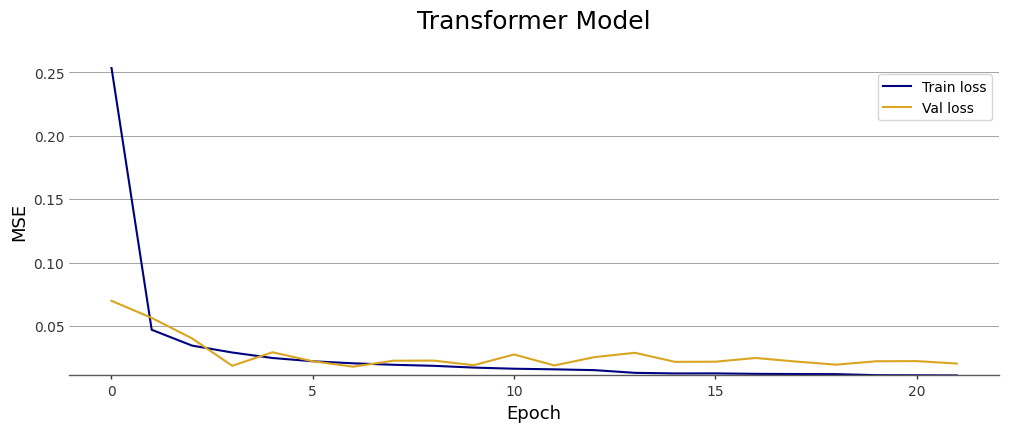

In [ ]:
plt.title("Transformer Model", size=18, y=1.1)
plt.plot(all_losses, label=["Train loss", "Val loss"])
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("MSE", fontsize=13)
plt.legend(loc="upper right", fontsize=10)
plt.show()

## EVALUATION

### Load best checkpoint

In [ ]:
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

### Predict

In [ ]:
def predict(data_loader, model):
    pred, true = torch.tensor([]).to(device), torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, dec_in, y in data_loader:
            X, dec_in, y = X.to(device), dec_in.to(device), y.to(device)
            src_mask = model.generate_square_subsequent_mask(X.shape[1]).to(device)
            tgt_mask = model.generate_square_subsequent_mask(dec_in.shape[1]).to(device)
            y_pred = model(X, dec_in, src_mask, tgt_mask)
            pred = torch.cat((pred, y_pred.permute(1,0,2).to(device)), 0)
            true = torch.cat((true, y.to(device)), 0)

    return pred, true

In [ ]:
y_pred, y_test = predict(test_loader, model)

# Inverse the transformation
y_pred_inv = np.expm1(y_pred.cpu())
y_test_inv = np.expm1(y_test.cpu())

### Metrics


In [ ]:
# Hours ahead to predict
forecast_length = 12

In [ ]:
truth = y_test_inv[:, forecast_length-1].numpy()
forecast = y_pred_inv[:, forecast_length-1].numpy()

diff = np.subtract(truth, forecast)
# MAPE
mape = np.mean(np.abs(diff / truth))
# RMSE
mse = np.mean(np.square(diff))
rmse = np.sqrt(mse)
# NSE
num = np.sum(np.square(diff))
den = np.sum(np.square(np.subtract(truth, truth.mean())))
nse = 1 - (num / den)

print(f"{forecast_length}-hour forecast MAPE : {mape:.4f}")
print(f"{forecast_length}-hour forecast RMSE: {rmse:.4f}")
print(f"{forecast_length}-hour forecast NSE: {nse:.4f}")

12-hour forecast MAPE : 0.0906
12-hour forecast RMSE: 13.7557
12-hour forecast NSE: 0.8722


### Visualize forecasts

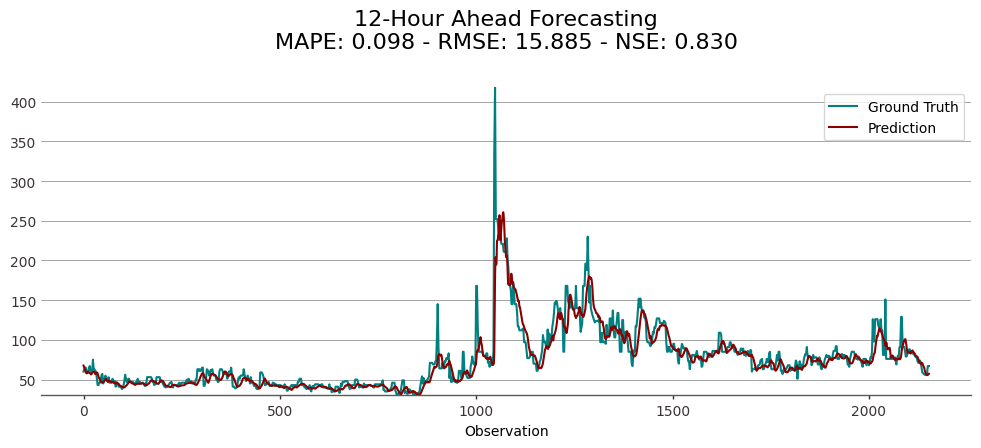

In [ ]:
plt.title(f"{forecast_length}-Hour Ahead Forecasting\nMAPE: {mape:.3f} - RMSE: {rmse:.3f} - NSE: {nse:.3f}", size=16, y=1.1)
plt.plot(truth, label="Ground Truth", color="teal")
plt.plot(forecast, label="Prediction", color="darkred")
plt.xlabel("Observation")
plt.legend(fontsize=10)
plt.show()